# Processing & Analysis of Biotek Plate Reader Records

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import string
import os
import matplotlib.pyplot as plt
import mwc.viz
colors = mwc.viz.personal_style()

In [2]:
# Define the experimental constants
DATE = 20190121
TEMP = 37

alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}
row_letters = {no:alpha for no, alpha in zip(np.arange(0, 27, 1),string.ascii_uppercase)}

# Load the data. 
data = pd.read_csv(f'output/growth_plate.csv')

FileNotFoundError: File b'output/growth_plate.csv' does not exist

## Clean Data

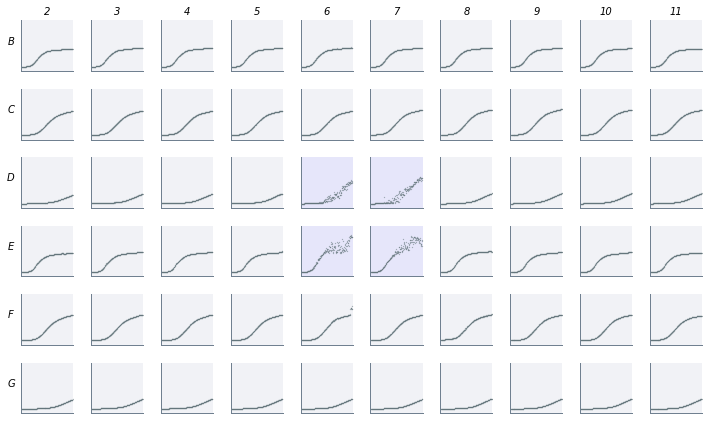

In [4]:
# Look for wells affected by plastic dust or OD spikes.
excluded_wells = []
for i in ['D6','D7','E6','E7']:
    excluded_wells.append(alphanumeric_map[i])

# Set viewing ranges
row_min, row_max, col_min, col_max = [1,7,1,11] 
# 0 refers to the first row or column (A or 1), so set the minimum 1 less than the coordinate of the row/column you want.
# To get the four middle rows, use 2,6. To get the eight middle columns, use 2,10.

fig, ax = plt.subplots(row_max-row_min, col_max-col_min, figsize=(10, 6))
for r in np.arange(row_min,row_max,1):
    for c in np.arange(col_min,col_max,1):
        ax[r-row_min][c-col_min].set_ylim([0, 1])
        ax[r-row_min][c-col_min].get_xaxis().set_visible(False)
        ax[r-row_min][c-col_min].get_yaxis().set_visible(False)
        row_letter = row_letters[r]
        well_id = alphanumeric_map[f'{row_letter}{c+1}']
        well_dat = data[data['well_id']==well_id]
        ax[r-row_min][c-col_min].scatter(well_dat['time_min'], well_dat['od_600nm'], marker='.', s=0.2)
        if well_id in excluded_wells:
            ax[r-row_min][c-col_min].set_facecolor('lavender')
for c in np.arange(0,col_max-col_min,1):
    ax[0][c].set_title(str(c+1+col_min),fontsize=10)
for r in np.arange(0,row_max-row_min,1):
    ax[r][0].get_yaxis().set_visible(True)
    ax[r][0].get_yaxis().set_ticks([])
    ax[r][0].set_ylabel(row_letters[r+row_min],rotation='horizontal',fontsize=10,labelpad=10)

plt.tight_layout()

The central wells have noise due to plastic dust debris.

In [5]:
# Remove dirty wells. 
data = data[~data.well_id.isin(excluded_wells)].copy()
data.to_csv(f'output/growth_plate.csv', index=False)

## Set Ranges for Analysis

### Subtract Background

In [6]:
# Generate a dictionary of the mean blank at each time point. 
blank_vals = {t:val['od_600nm'].mean() for t, val in data[data['strain']=='blank'].groupby(['time_min'])}

# Add mean blank values for each time point to the dataframe, as well as background subtracted OD values.
for k, v in blank_vals.items():
    data.loc[data['time_min']==k, 'blank_val'] = v
data['od_sub'] = data['od_600nm'] - data['blank_val']

### Delta in Glucose

In [7]:
current_strain = 'delta'
current_carbon = 'glucose'

# Create strain-carbon output directory
if os.path.exists(f'./output/{current_strain}_{current_carbon}') == False:
    os.mkdir(f'./output/{current_strain}_{current_carbon}')

#### Plot the Data

In [17]:
# Save range(s)
ranges = [['deltaglucose'],[200],[425]] #[list of growth conditions ('straincarbon'), list of min times, list of max times]
np.savetxt(f'output/ranges.csv',ranges,fmt='%s', delimiter=',')

In [18]:
# Load range
ranges_df = pd.read_csv('output/ranges.csv')
XMIN = ranges_df[current_strain+current_carbon][0]
XMAX = ranges_df[current_strain+current_carbon][1]

View full curve and exponential subset.

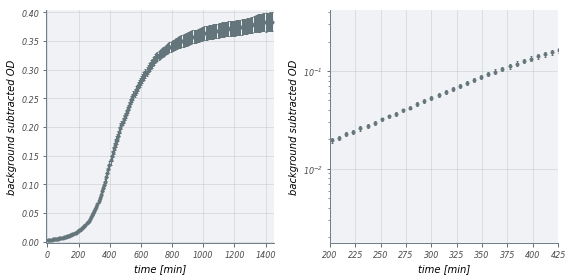

In [19]:
# Plot the growth data. 
grouped = data[(data['strain']==current_strain) & (data['carbon']==current_carbon)].groupby(
    ['time_min']).agg(('mean', 'std')).reset_index()
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].set_xlabel('time [min]', fontsize=10)
    ax[i].set_ylabel('background subtracted OD', fontsize=10)

ax[1].set_yscale('log')
ax[1].set_xlim([XMIN, XMAX])
ax[0].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
ax[1].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
plt.tight_layout()
plt.savefig(f'output/{current_strain}_{current_carbon}/growth_curves_full_and_inset.png')

View the exponential region up close.

Text(0,0.5,'background subtracted OD')

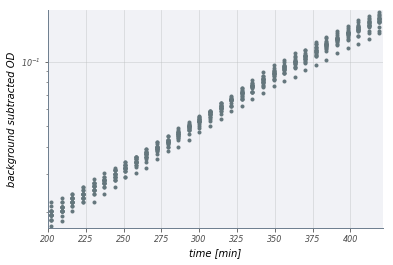

In [20]:
# Restrict to the desired range
restricted = data[(data['strain']==current_strain) & (data['carbon']==current_carbon) & 
                  (data['time_min'] >= XMIN) & (data['time_min'] <= XMAX)].copy()
# Plot the data
fig, ax = plt.subplots(1, 1)
ax.semilogy(restricted['time_min'], restricted['od_sub'], '.')
ax.set_xlabel('time [min]', fontsize=10)
ax.set_ylabel('background subtracted OD', fontsize=10)

View restricted region without log scaling.

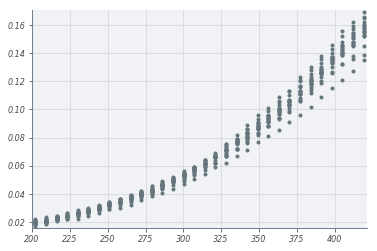

In [21]:
plt.plot(restricted['time_min'], restricted['od_sub'], '.')

### Delta in Glycerol

In [22]:
current_strain = 'delta'
current_carbon = 'glycerol'

# Create strain-carbon output directory
if os.path.exists(f'./output/{current_strain}_{current_carbon}') == False:
    os.mkdir(f'./output/{current_strain}_{current_carbon}')

#### Plot the Data

In [26]:
# Save range(s)
ranges = [['deltaglucose','deltaglycerol'],[200,300],[425,650]] #[list of growth conditions ('straincarbon'), list of min times, list of max times]
np.savetxt(f'output/ranges.csv',ranges,fmt='%s', delimiter=',')

In [27]:
# Load range
ranges_df = pd.read_csv('output/ranges.csv')
XMIN = ranges_df[current_strain+current_carbon][0]
XMAX = ranges_df[current_strain+current_carbon][1]

View full curve and exponential subset.

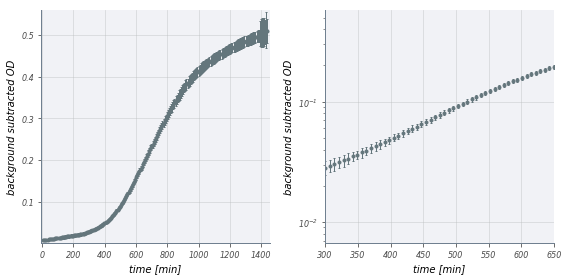

In [28]:
# Plot the growth data. 
grouped = data[(data['strain']==current_strain) & (data['carbon']==current_carbon)].groupby(
    ['time_min']).agg(('mean', 'std')).reset_index()
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].set_xlabel('time [min]', fontsize=10)
    ax[i].set_ylabel('background subtracted OD', fontsize=10)

ax[1].set_yscale('log')
ax[1].set_xlim([XMIN, XMAX])
ax[0].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
ax[1].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
plt.tight_layout()
plt.savefig(f'output/{current_strain}_{current_carbon}/growth_curves_full_and_inset.png')

View the exponential region up close.

Text(0,0.5,'background subtracted OD')

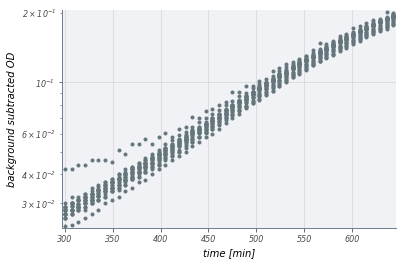

In [29]:
# Restrict to the desired range
restricted = data[(data['strain']==current_strain) & (data['carbon']==current_carbon) & 
                  (data['time_min'] >= XMIN) & (data['time_min'] <= XMAX)].copy()
# Plot the data
fig, ax = plt.subplots(1, 1)
ax.semilogy(restricted['time_min'], restricted['od_sub'], '.')
ax.set_xlabel('time [min]', fontsize=10)
ax.set_ylabel('background subtracted OD', fontsize=10)

View restricted region without log scaling.

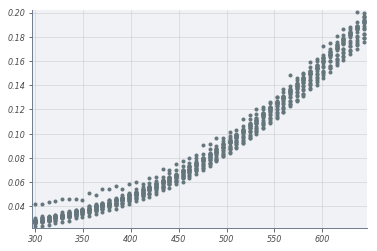

In [30]:
plt.plot(restricted['time_min'], restricted['od_sub'], '.')

### Delta in Acetate

In [31]:
current_strain = 'delta'
current_carbon = 'acetate'

# Create strain-carbon output directory
if os.path.exists(f'./output/{current_strain}_{current_carbon}') == False:
    os.mkdir(f'./output/{current_strain}_{current_carbon}')

#### Plot the Data

In [35]:
# Save range(s)
ranges = [['deltaglucose','deltaglycerol','deltaacetate'],[200,300,750],[425,650,1150]] #[list of growth conditions ('straincarbon'), list of min times, list of max times]
np.savetxt(f'output/ranges.csv',ranges,fmt='%s', delimiter=',')

In [36]:
# Load range
ranges_df = pd.read_csv('output/ranges.csv')
XMIN = ranges_df[current_strain+current_carbon][0]
XMAX = ranges_df[current_strain+current_carbon][1]

View full curve and exponential subset.

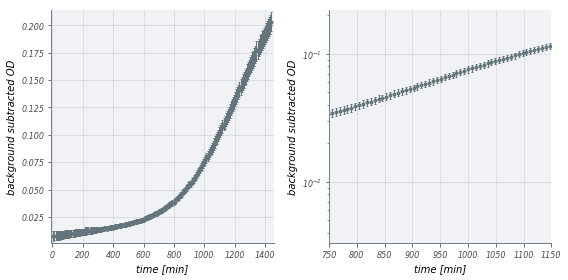

In [37]:
# Plot the growth data. 
grouped = data[(data['strain']==current_strain) & (data['carbon']==current_carbon)].groupby(
    ['time_min']).agg(('mean', 'std')).reset_index()
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].set_xlabel('time [min]', fontsize=10)
    ax[i].set_ylabel('background subtracted OD', fontsize=10)

ax[1].set_yscale('log')
ax[1].set_xlim([XMIN, XMAX])
ax[0].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
ax[1].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
plt.tight_layout()
plt.savefig(f'output/{current_strain}_{current_carbon}/growth_curves_full_and_inset.png')

View the exponential region up close.

Text(0,0.5,'background subtracted OD')

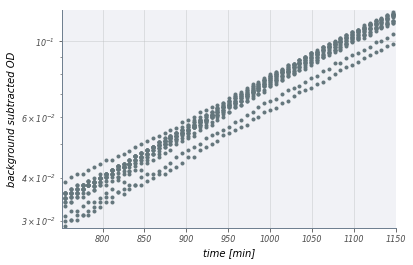

In [38]:
# Restrict to the desired range
restricted = data[(data['strain']==current_strain) & (data['carbon']==current_carbon) & 
                  (data['time_min'] >= XMIN) & (data['time_min'] <= XMAX)].copy()
# Plot the data
fig, ax = plt.subplots(1, 1)
ax.semilogy(restricted['time_min'], restricted['od_sub'], '.')
ax.set_xlabel('time [min]', fontsize=10)
ax.set_ylabel('background subtracted OD', fontsize=10)

View restricted region without log scaling.

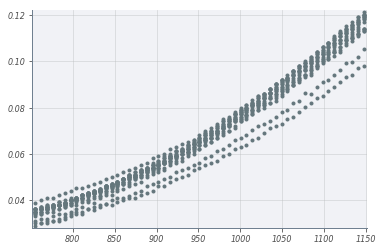

In [39]:
plt.plot(restricted['time_min'], restricted['od_sub'], '.')